In [1]:
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import pyro
import seaborn as sns

pyro.settings.set(module_local_params=True)

sns.set_style("white")

# Set seed for reproducibility
seed = 123
pyro.clear_param_store()
pyro.set_rng_seed(seed)


import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from collab.foraging import locust as lc
from collab.foraging import toolkit as ft
from collab.utils import find_repo_root

smoke_test = "CI" in os.environ
subset_starts = 1  # 420
subset_ends = 30 if smoke_test else 900
desired_frames = 50 if smoke_test else 180
num_iterations = 50 if smoke_test else 2000
num_samples = 20 if smoke_test else 500
num_steps = 10 if smoke_test else 100
sample_size = 100 if smoke_test else 1000
locust_sample_size = 100 if smoke_test else 178770
root = find_repo_root()


notebook_starts = time.time()

In [2]:
locust_data_path = os.path.join(root, "data/foraging/locust/15EQ20191202_tracked.csv")

df = lc.load_and_clean_locust(
    path=locust_data_path,
    desired_frames=desired_frames,
    grid_size=100,
    rewards_x=[0.68074, -0.69292],
    rewards_y=[-0.03068, -0.03068],
    subset_starts=subset_starts,
    subset_ends=subset_ends,
)

locust_object = df["subset"]
rewards = (
    locust_object.rewardsDF.iloc[:, [0, 1]].drop_duplicates().reset_index(drop=True)
)
df = locust_object.foragersDF
start, end, N_obs = min(df["time"]), max(df["time"]), len(df["time"].unique())

display(locust_object.rewardsDF)

original_frames: 45000
original_shape: (675000, 4)
resulting_frames: 180
resulting_shape: (2700, 4)
min_time 1
max_time 180
frames diff 899
desired_frames 180


,x,y,time
0,84.0,48.0,1
1,15.0,48.0,1
2,84.0,48.0,2
3,15.0,48.0,2
4,84.0,48.0,3
...,...,...,...
355,15.0,48.0,178
356,84.0,48.0,179
357,15.0,48.0,179
358,84.0,48.0,180


In [3]:
ft.animate_foragers(
    locust_object,
    plot_rewards=True,
    height=600,
    point_size=10,
)

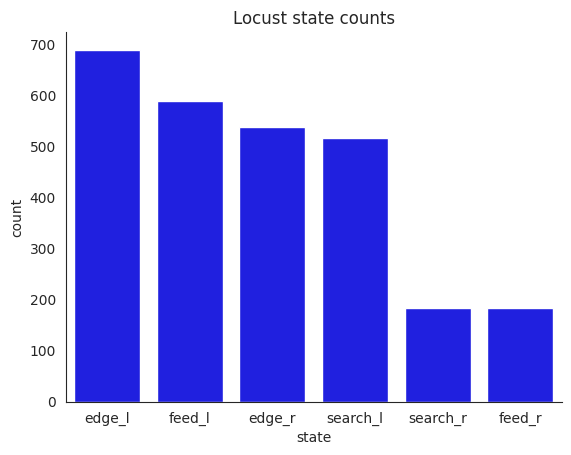

In [4]:
df_cat = lc.compartmentalize_locust_data(
    rewards, df, center=50, feeding_radius=10, edge_ring_width=4
)


sns.barplot(
    x=df_cat["state"].value_counts().index,
    y=df_cat["state"].value_counts(),
    color="blue",
)
sns.despine()
plt.title("Locust state counts")
plt.show()

In [5]:
unique_states = set(df_cat["state"])

# these will be added to ensure the animation starts with
# all states represented
# ignore the initial frame in the animation
initial_fake_positions = pd.DataFrame(
    {
        "x": np.zeros(len(unique_states), dtype=int),
        "y": np.zeros(len(unique_states), dtype=int),
        "state": sorted(list(unique_states)),
        "time": [(start - 1)] * len(unique_states),
        "forager": np.zeros(len(unique_states), dtype=int),
    }
)

df_cat_vis = pd.concat([initial_fake_positions, df_cat])
locust_object.foragersDF = df_cat_vis

ft.animate_foragers(
    locust_object,
    plot_rewards=True,
    height=600,
    point_size=10,
    color_by_state=True,
)

In [6]:
data_path = "data/foraging/locust/ds/locust_counts15EQ20191202.pkl"
count_data_dic = ft.tensorize_and_dump_count_data(df_cat, data_path)

dict_keys(['search_r_obs', 'feed_l_obs', 'edge_r_obs', 'search_l_obs', 'edge_l_obs', 'feed_r_obs'])


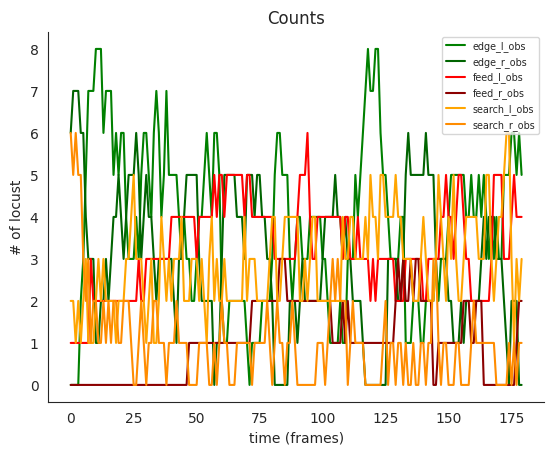

In [7]:
count_data = count_data_dic["count_data"]

print(count_data.keys())
ft.plot_ds_trajectories(count_data, window_size=0, observed=True)

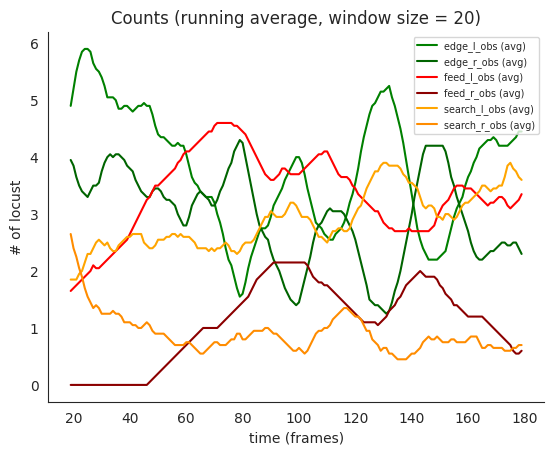

In [8]:
ft.plot_ds_trajectories(count_data, window_size=20, observed=True)

In [9]:
notebook_ends = time.time()
print(
    "notebook took",
    notebook_ends - notebook_starts,
    "seconds, that is ",
    (notebook_ends - notebook_starts) / 60,
    "minutes to run",
)

notebook took 13.600520849227905 seconds, that is  0.22667534748713175 minutes to run
